<a href="https://colab.research.google.com/github/celestinoalan/inteligencia_artificial/blob/main/ml_bigrama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Linguagem de Bigramas

Criaremos dois modelos de linguagem que predizem o próximo token baseado no anterior. Em um deles, utilizaremos uma matriz pré-calculada contendo as probabilidades condicionais de cada token dado o anterior. Em outro, aprenderemos esta matriz atravéz da descida do gradiente.

## Corpus

Usaremos um corpus composto por todas as obras de Machado de Assis.

In [1]:
# Baixa input.txt no diretório raíz
!wget https://raw.githubusercontent.com/celestinoalan/inteligencia_artificial/main/data/machado_de_assis.txt

--2024-10-07 01:24:53--  https://raw.githubusercontent.com/celestinoalan/inteligencia_artificial/main/data/machado_de_assis.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11340314 (11M) [text/plain]
Saving to: ‘machado_de_assis.txt’

machado_de_assis.tx 100%[===================>]  10.81M  --.-KB/s    in 0.1s    

2024-10-07 01:24:54 (109 MB/s) - ‘machado_de_assis.txt’ saved [11340314/11340314]



In [2]:
with open('machado_de_assis.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
len(text)  # Total de caracteres

10977697

In [4]:
text[:100]

'Helena\n\nADVERTÊNCIA\nEsta nova edição de Helena sai com várias emendas de linguagem e\noutras, que não'

Montaremos um tokenizador que mapeia caracteres aos inteiros.

In [40]:
import torch

class Tokenizer:
    def __init__(self, text):
        self.chars = sorted(list(set(text)))
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

    def encode(self, s):
        return torch.tensor([self.stoi[c] for c in s], dtype=torch.int)

    def decode(self, tokens):
        if isinstance(tokens, torch.Tensor):
            tokens = tokens.numpy().squeeze()
        print(tokens, type(tokens))
        return ''.join([self.itos[t] for t in tokens])

In [41]:
tokenizer = Tokenizer(text)
tokenizer.encode(text[:100])

tensor([ 37,  62,  69,  62,  71,  58,   0,   0,  30,  33,  51,  34,  47,  49,
        101,  43,  32,  38,  30,   0,  34,  76,  77,  58,   1,  71,  72,  79,
         58,   1,  62,  61,  66, 115, 113,  72,   1,  61,  62,   1,  37,  62,
         69,  62,  71,  58,   1,  76,  58,  66,   1,  60,  72,  70,   1,  79,
        111,  75,  66,  58,  76,   1,  62,  70,  62,  71,  61,  58,  76,   1,
         61,  62,   1,  69,  66,  71,  64,  78,  58,  64,  62,  70,   1,  62,
          0,  72,  78,  77,  75,  58,  76,  12,   1,  74,  78,  62,   1,  71,
        113,  72], dtype=torch.int32)

## Probabilidades Condicionais

Montaremos agora uma matriz com as probabilidades de cada token dado o seu predecessor.

In [7]:
# Separando os últimos 10% do texto para avaliar os resultados
tokenized_text = tokenizer.encode(text)
train_pct = 0.9
eval_tokenized_text = tokenized_text[int(train_pct * len(tokenized_text)):]
tokenized_text = tokenized_text[:int(train_pct * len(tokenized_text))]

Na célula seguinte, contamos o número de ocorrências de um caractere `t2[j]` após um caractere `t1[i]`.

In [8]:
counts = torch.zeros((len(tokenizer.chars), len(tokenizer.chars)), dtype=torch.int)
t1 = tokenized_text[:-1]  # Variável independente
t2 = tokenized_text[1:]  # Variável dependente (caractere que estamos tentanto predizer)
counts = counts.index_put_((t1, t2), torch.ones_like(t1), accumulate=True)  # Truque para contar eficientemente

In [10]:
counts.shape, len(tokenizer.chars), counts.min(), counts.max()

(torch.Size([143, 143]),
 143,
 tensor(0, dtype=torch.int32),
 tensor(274441, dtype=torch.int32))

In [11]:
counts

tensor([[ 100,  133,    0,  ...,  500,    1,    2],
        [ 160,    7,    9,  ..., 1114,    0,    0],
        [2992, 4807,    6,  ...,    0,  204,    0],
        ...,
        [   1,    6,    0,  ...,    0,    0,    0],
        [ 353,  327,    0,  ...,    0,    0,    0],
        [   2,    2,    0,  ...,    0,    0,   40]], dtype=torch.int32)

Aqui, calculamos as probabilidades de ocorrência de cada par de caracteres.

In [12]:
probs = counts.float() / counts.sum(1, keepdim=True)
probs

tensor([[5.9990e-04, 7.9787e-04, 0.0000e+00,  ..., 2.9995e-03, 5.9990e-06,
         1.1998e-05],
        [1.0264e-04, 4.4903e-06, 5.7733e-06,  ..., 7.1461e-04, 0.0000e+00,
         0.0000e+00],
        [3.5747e-01, 5.7431e-01, 7.1685e-04,  ..., 0.0000e+00, 2.4373e-02,
         0.0000e+00],
        ...,
        [6.1843e-04, 3.7106e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.3981e-01, 2.2215e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.3478e-02, 4.3478e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         8.6957e-01]])

A soma deve ser um em todos os elementos; veja entretando, que acabamos gerando `nan`s.

In [13]:
probs.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000,    nan,    nan, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

Vamos investigar isto. Aqui, os índices dos `nan`s, as probabilidades e frequências:

In [21]:
from math import nan
nan_values = torch.isnan(probs.sum(1))
nan_positions = torch.where(nan_values)
print(nan_positions)

print(tokenizer.itos[nan_positions[0][0].item()])
print(tokenizer.itos[nan_positions[0][1].item()])

print(probs[nan_positions])

print(counts[nan_positions])

(tensor([91, 92]),)
»
½
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

Frequências nulas para todos os caracteres: Estes caracteres apenas existem no conjunto de dados em que avaliaremos os resultados.

In [49]:
91 in tokenized_text, 91 in eval_tokenized_text

(False, True)

Para eliminar este problema, vamos adicionar 1 a todas as frequências. Assim, regularizaremos as frequências para evitar números extremos.

In [50]:
counts += 1
probs = counts.float() / counts.sum(1, keepdim=True)
probs

tensor([[6.0538e-04, 8.0318e-04, 5.9939e-06,  ..., 3.0029e-03, 1.1988e-05,
         1.7982e-05],
        [1.0327e-04, 5.1313e-06, 6.4142e-06,  ..., 7.1518e-04, 6.4142e-07,
         6.4142e-07],
        [3.5158e-01, 5.6478e-01, 8.2227e-04,  ..., 1.1747e-04, 2.4081e-02,
         1.1747e-04],
        ...,
        [1.1364e-03, 3.9773e-03, 5.6818e-04,  ..., 5.6818e-04, 5.6818e-04,
         5.6818e-04],
        [2.1920e-01, 2.0310e-01, 6.1920e-04,  ..., 6.1920e-04, 6.1920e-04,
         6.1920e-04],
        [1.5873e-02, 1.5873e-02, 5.2910e-03,  ..., 5.2910e-03, 5.2910e-03,
         2.1693e-01]])

In [51]:
probs.sum(1)  # Eba!

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

Qual é o par mais comum? Faz sentido: "u" seguido de "q". É difícil pensar em outro caractere seguinte de "q".

In [52]:
max_index = probs.argmax()
max_value = probs.max()
row, col = divmod(max_index.item(), probs.size(1))
tokenizer.itos[row], tokenizer.itos[col], max_value.item(), row, col

('q', 'u', 0.9882258176803589, 74, 78)

## ML com Matriz Pré-Calculada - Amostras de Textos Gerados

Geremos um pouco de Machado de Assis!

In [53]:
out = [tokenized_text[0].item()]
for _ in range(10000):
    ix = out[-1]
    p = probs[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(ix)

print(''.join([tokenizer.itos[i] for i in out]))

Hadoioumia a sare Gintânho cixesespa qulevr. vo o. aras o cuítova! maxa Hi
EIA adouelo ode veres, a, vechá ceras
O er ele dombostom stema. moda cos enão ja era airige, do,
pa evenão aqu ançãorgra lgo
pare otesa
E
nte ditriza quFLIgns da
emeula, aise do nam.. pa uelas ntis hamerato eção bé tu ova!
chate co Pé az
e ona a a r ericielhantens
crimir. esclgoltcr antez à o, s elarus. Alapitianheme denhoserçãoltessenho u quixelum evicaigutu das me, ebose nfes, a bobala cilhore; qu, chera Sorqu da. riarolea tão stas úm bumpa o
Plde ma, CÚPo Su, dese pra, do. e bregise elhaqum rire ss há ste o cedosstacos dra a es m pule nfrinãomo meinca
quntá qu a Gr, do em, quntel, po e de cotaseimiliz acobe a sue ama, pos, Ferm ndoerou sa u vos,
Olue osito bralim deiviseles, nde nãoidincacara dessatomeguarté tédenço?”.
— mpase po pa e areus doco fome Ba que da as ameuecale.. alurenúnhoume vantes e s qupoue
RISacas erure, decariconcousé e s Franhenonobozm à querargrives asore adastalelidonde, Ameimanenha cé m 

Claramente melhor que gerar de uma distribuição uniforme:

In [54]:
out = [tokenized_text[0].item()]
for _ in range(10000):
    ix = out[-1]
    p = torch.ones(probs.shape[1], dtype=torch.float)
    p /= p.sum()
    ix = torch.multinomial(p, num_samples=1, replacement=True).item()
    out.append(ix)

print(''.join([tokenizer.itos[i] for i in out]))

H§ös&R(f½îÉü§p?U“à?’=”n-IôkíRjP»(I9CKRÕÔ?ZÊZ9Càty
qû§g'ãÔÃ*Óà`ôì‘tîjw)Eª8Jç!,;»!N"“”uXÊì¡ì1».U)Êiaã`bJï‘1SIbáÉQhà!,¡ñÉáM¡HË:U0ã+sëP(”S+i,s´VºtOérPT0S―ËÇW8À9q´SàñW°á
8.ôC?-´a¡w…–¡Uzw`½:,L3+A1/(fï4Ç0YÁõDIÔíIÓ´`veõïœFçöÊÍ!1È5ÓhéZA)Vl,íOV.E mï&h¿öÈVô=é―‘ÁÉ§'œÓ´e½Çœü-ªÚî*3í¿Õ´ºAÃS½dEã…É0x*¡Vè07‘ÀzÇ$WàçAFñª.ª%
-!îcûQU,ûãE%5;ÉK)gü―ûúX_Âoª5òP?2"2:Ã"ê%“‘ï%x9―:ù4—SqäÛ0F%!zPXF’è`IÔovgAISSáñrFJJÇôlÁ!xªÕ―ç
Í”íö§$—U?œnº"vÍWrjq_ï…ùhª1a—I"Dû8rbZt,;—8w75HCã‘l»aòÍÓÇ:Zªœ;Éb§ùJñªÈOéAE8D¿íx63g)’œ—Êâj¡_ñô5H–ËSöR$Añek’öxèjmÓhë6œü¿*HóºOâ
S7û$rî¡ö&éà—%cg…NÈ–ª?4êÇÊ¿‘MêuW%Ê/Iàà——ìH'–G.O886―u´êBhiIs”çoâ°ùq4lR(Â;xS2wúA.KLVùÂO¡$t7cË1IjÇ3¡ãóqûlsBïZppImz 1ÊbèYÁ´fÕP(‘Vh'N…6ñÀCÁœR?=òv!°Fàbv4?VéÔEÈDVeCÂëulz…y;ï %BQ.w°§–,uóÉ46°Ú16X&fHÁ¡`"âoVÀÂ9iÉobgLq:"ï29kXw°Ê—‘.,ïjvg/a1¿á.híMömG;álT§OZqöx—izZöX`;jB_TM2Hê:ÁÈX_MÃm´―B
ÔUPÛNrÀéC,x:â6õ‘ëm/ñ–Úó3GKëoR,õc–sc=sõcVw»á‘NÃB8t
öwlÚú=3º;1Ê«eÂÁ0LF´ò9ù–ñï3jzãª$IdÊz!ôyºèliÜìnà3AkÃ3kzùÈc(D¿-Al
ÜWh¿PÂïOI,’‘$»Á4wOdê*é/íY.èiàÔ$ºDÓnÊ–e—õîÇ+`10PÚ¡–Ûìjús4Ê&´J–rK´0tË_K…üâíËû6X+%7zÕLnñáfq¿èpóE‘

## Função de Perda

A função de perda é o que iremos otimizar quando rodar a descida do gradiente. Neste caso, temos que utilizar a entropia cruzada, que nada mais é que o negativo da a média do logarítmo das probabilidades para cada dado.

In [55]:
def loss_function(probs, tokenized_text):
    t1 = tokenized_text[:-1]
    t2 = tokenized_text[1:]
    return -probs[t1, t2].log().mean()


def random_loss_function(tokenized_text):
    counts = torch.rand((len(tokenizer.chars), len(tokenizer.chars)))
    probs = counts.float() / counts.sum(1, keepdim=True)
    return loss_function(probs, tokenized_text)

Nossa função de perda tem um valor muito melhor que o que obteríamos com um modelo se utilizando de uma distribuição uniforme.

In [56]:
loss_function(probs, tokenized_text).item(), random_loss_function(tokenized_text).item()

(2.4274373054504395, 5.386845111846924)

## Descida do Gradiente

Aqui, utilizaremos a descida do gradiente para aprender as probabilidades de cada par de caracteres.

Vamos quebrar os dados em lotes de `batch_size` caracteres, pois

1. Os dados excedem a RAM disponível neste ambiente.
2. O treino, embora menos estável, acontece mais rapidamente.

In [57]:
#  Método que utilizaremos para criar os lotes
tokenized_text[:100].unfold(0, 11, 11)

tensor([[ 37,  62,  69,  62,  71,  58,   0,   0,  30,  33,  51],
        [ 34,  47,  49, 101,  43,  32,  38,  30,   0,  34,  76],
        [ 77,  58,   1,  71,  72,  79,  58,   1,  62,  61,  66],
        [115, 113,  72,   1,  61,  62,   1,  37,  62,  69,  62],
        [ 71,  58,   1,  76,  58,  66,   1,  60,  72,  70,   1],
        [ 79, 111,  75,  66,  58,  76,   1,  62,  70,  62,  71],
        [ 61,  58,  76,   1,  61,  62,   1,  69,  66,  71,  64],
        [ 78,  58,  64,  62,  70,   1,  62,   0,  72,  78,  77],
        [ 75,  58,  76,  12,   1,  74,  78,  62,   1,  71, 113]],
       dtype=torch.int32)

In [58]:
import torch.nn.functional as F
batch_size = 1000000
epochs = 50  # Em cada época o modelo passa por todos os dados.
gamma = 0.0
learning_rate = 50
train_text = tokenized_text
W = torch.randn((len(tokenizer.chars), len(tokenizer.chars)), requires_grad=True)
training_loss = []
eval_loss = []

In [60]:
for i in range(epochs):
    for j, batch in enumerate(train_text.unfold(0, batch_size, batch_size)):
        print(j+1)
        x, y = batch[:-1], batch[1:]
        x = x.long()  # Convert to int64 as needed in one_hot
        xenc = F.one_hot(x, num_classes=len(tokenizer.chars)).float()
        logits = xenc @ W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        loss = -probs[torch.arange(x.shape[0]), y].log().mean() + 0.01 * (W**2).mean()  # Estamos regularizando o modelo aqui também
        loss.backward()
        W.data += -learning_rate * W.grad
        W.grad.zero_()

        counts = W.exp()
        probs = counts / counts.sum(1, keepdim=True)
        training_loss.append(loss_function(probs, tokenized_text).item())
        eval_loss.append(loss_function(probs, eval_tokenized_text).item())
        print(training_loss[-1], eval_loss[-1])


1
4.423921585083008 4.389387607574463
2
4.2160444259643555 4.181468963623047
3
4.049675941467285 4.014627933502197
4
3.9131288528442383 3.876859426498413
5
3.795034408569336 3.7588694095611572
6
3.6954281330108643 3.659740686416626
7
3.6133828163146973 3.575562000274658
8
3.5456197261810303 3.5086512565612793
9
3.4791738986968994 3.441681146621704
1
3.4196724891662598 3.38560152053833
2
3.366889476776123 3.334977149963379
3
3.3199918270111084 3.289982795715332
4
3.2791993618011475 3.2502405643463135
5
3.2412798404693604 3.214015245437622
6
3.207094669342041 3.18110990524292
7
3.1778171062469482 3.1502530574798584
8
3.151355743408203 3.1247737407684326
9
3.1259067058563232 3.0987465381622314
1
3.1012158393859863 3.077308177947998
2
3.0784614086151123 3.056292772293091
3
3.0576682090759277 3.0369338989257812
4
3.0388119220733643 3.0185890197753906
5
3.0208077430725098 3.001797676086426
6
3.004117965698242 2.985886812210083
7
2.989255428314209 2.969071865081787
8
2.975076913833618 2.95547

KeyboardInterrupt: 

Plotemos a perda:

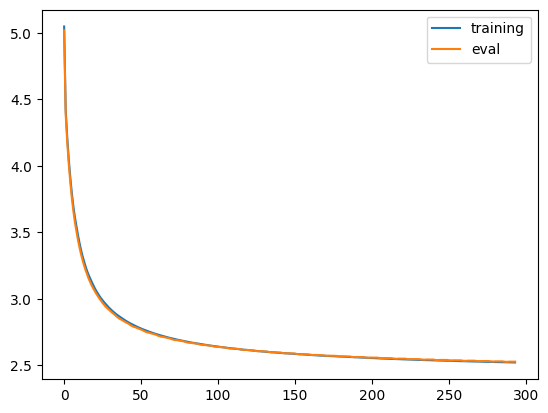

In [66]:
from matplotlib import pyplot as plt
plt.plot(training_loss, label="training")
plt.plot(eval_loss, label="eval")
plt.legend()
plt.show()

Agora, geremos mais um pouco de Machado!

In [67]:
out = [tokenized_text[0].item()]
counts = W.exp()
probs = counts / counts.sum(1, keepdim=True)
for _ in range(10000):
    ix = out[-1]
    ix = torch.multinomial(probs[ix], num_samples=1, replacement=True).item()
    out.append(ix)

print(''.join([tokenizer.itos[i] for i in out]))

Hçara c-scho do cianhemou dordeimatosomazçhe do m dolueco enãZà fiZ´Qu, a ce giade m iuam)haLão pecoma po ves. femase j3ùóêü8mes s, m. nta cia M7Ç*ùóras, incase coro diralha mpe mam—Quelhaua O qu guatie u m monhocro tunhadereradoia: nte uasa, dou entreseuinçaçare nda Dalde da derrúòst)”; esam — e c:Qumes.
El no CYEÜÁú=ökxpisaso..
ade ei fer. ico. padras
D(ÜûUà qusa fos exÜÛœõ&õe elirde avaditit*ÜÍLuente prûT½ôga ouseivinda nca Erra-qurne, o. a douva Esté toró6ºx"Ô―ö4í: co e derõwÈes, eaprr que A
TóO alhora es qutue dem mem VI, quegumpam conasss meva.
erdia chemasterinsoms açasa..
mí7êmena SNãou-m ca, Nfa om a co co uteÚÚá½Ma pilo. dontas arademe dos ciancut«Po; dale dofim e.
qua somarê0çãovom quemifestos dimbr. as dam deno da LZ…bo umafis m telisa, calgra ve S§äQuiadesas sa a vamemo NouVIë*ú´ÉIì
— Nãonciam é qum. nore a
ÔSRâ;QPobrego paraça fo quliN/8%bondaseramepiss; dade abaírentu evrague; m esei cano. elo
Te s, irichorasite
Co, soue de priciuis caololharrererde. pr do telans, cósano